## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

### Prepare
Check environment. Install packages if in Colab.


In [93]:
import sys
import os
import requests

import torch
import torchvision
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T

# check whether run in Colab
# if 'google.colab' in sys.modules:
#     print('Running in Colab.')
#     !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
#     !git clone https://github.com/facebookresearch/mae.git
#     sys.path.append('./mae')
# else:
#     sys.path.append('..')
import models_mae

In [11]:
import sys
print(sys.version)

3.9.13 (main, Aug 25 2022, 18:29:29) 
[Clang 12.0.0 ]


### Define utils

In [131]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()
    return x[0], im_paste[0]

### Load an image

In [141]:
# load an image
def load_image(image_name):
    img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
    # img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
    img = Image.open(image_name)
    img = img.resize((224, 224))
    img = np.array(img) / 255.
    if img.shape != (224, 224, 3):
        return img
#     assert img.shape == (224, 224, 3) or img.shape == (224, 224)

    # normalize by ImageNet mean and std
    img = img - imagenet_mean
    img = img / imagenet_std
    

    plt.rcParams['figure.figsize'] = [5, 5]
    show_image(torch.tensor(img))
    return img

### Load a pre-trained MAE model

In [14]:
# This is an MAE model trained with pixels as targets for visualization (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large.pth

chkpt_dir = 'mae_visualize_vit_large.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
print('Model loaded.')


File 'mae_visualize_vit_large.pth' already there; not retrieving.

<All keys matched successfully>
Model loaded.


### Run MAE on the image

MAE with pixel reconstruction:


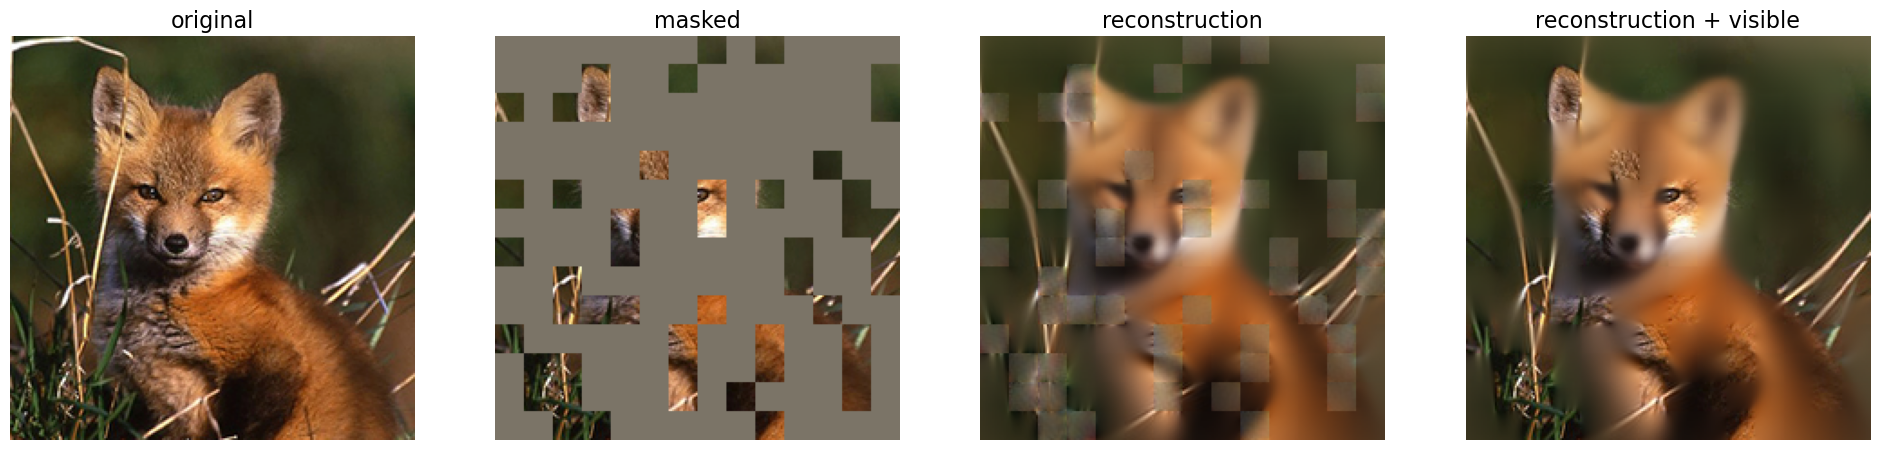

In [15]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img, model_mae)

### Load another pre-trained MAE model

In [16]:
# This is an MAE model trained with an extra GAN loss for more realistic generation (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large_ganloss.pth

chkpt_dir = 'mae_visualize_vit_large_ganloss.pth'
model_mae_gan = prepare_model('mae_visualize_vit_large_ganloss.pth', 'mae_vit_large_patch16')
print('Model loaded.')

File 'mae_visualize_vit_large_ganloss.pth' already there; not retrieving.

<All keys matched successfully>
Model loaded.


### Run MAE on the image

MAE with extra GAN loss:


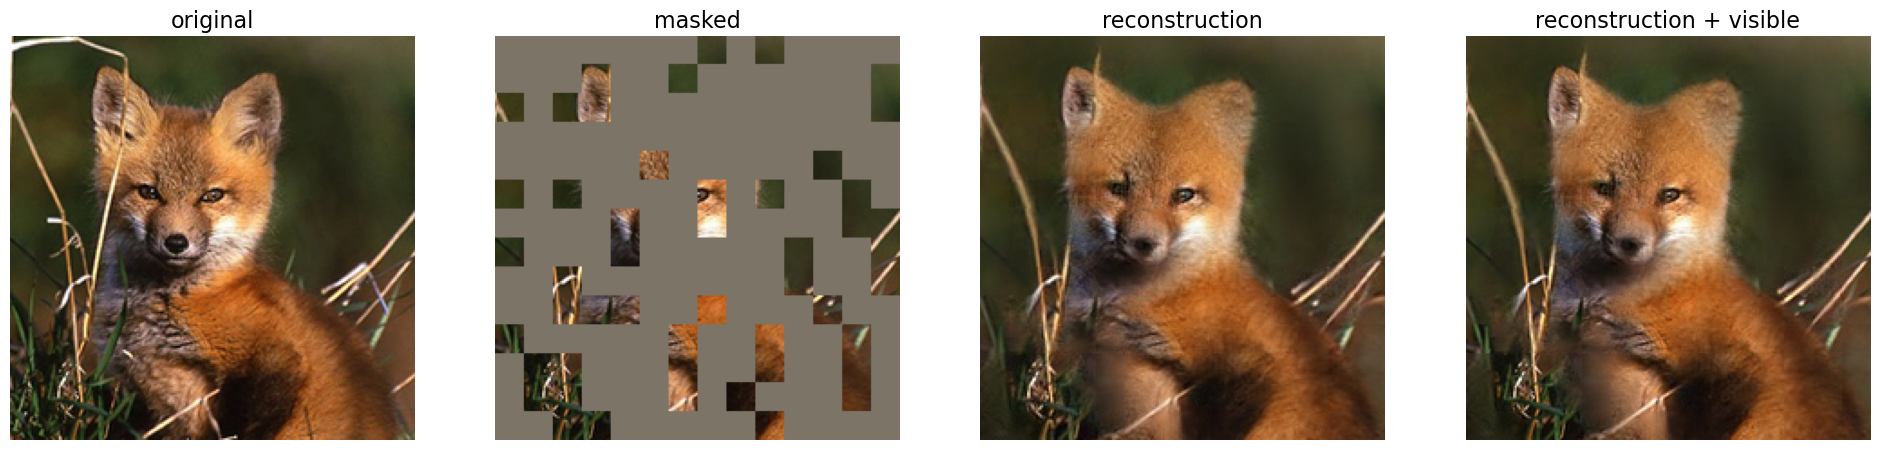

In [17]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with extra GAN loss:')
run_one_image(img, model_mae_gan)

# Processing High frequency images from Image Net

In [ ]:
hf_rmse

In [88]:
original1.ndim

3

In [53]:
# output1 = torch.mean(output, dim=0, keepdim=True)  # Convert to grayscale
# original1 = torch.mean(original, dim=0, keepdim=True)  # Convert to grayscale

# Calculate the element-wise squared differences
squared_diff = (output - original) ** 2

# Calculate the mean of the squared differences
mean_squared_diff = torch.mean(squared_diff)

# Calculate the RMSE value
rmse = torch.sqrt(mean_squared_diff)
float(rmse)

In [104]:
original1.flatten()[0]

tensor(254, dtype=torch.int32)

In [ ]:
imagenet_lf_rmse = []
low_frequency_images = os.listdir("ImageNetWorst/")
len(low_frequency_images)
for image in low_frequency_images:
    print(f"ImageNetWorst/{image}")
    image = load_image(f"ImageNetWorst/{image}")
    if image.shape != (224, 224, 3):
        continue
    original, output = run_one_image(image, model_mae)
    output1 = torch.clip((output * imagenet_std + imagenet_mean) * 255, 0, 255).int().flatten()
    original1 = torch.clip((original * imagenet_std + imagenet_mean) * 255, 0, 255).int().flatten()
    squared_diff = (output1 - original1) ** 2
    # Calculate the mean of the squared differences
    mean_squared_diff = torch.mean(squared_diff* 1.0)

    # Calculate the RMSE value
    rmse = float(torch.sqrt(mean_squared_diff))
    imagenet_lf_rmse.append(rmse)

In [ ]:
imagenet_hf_rmse = []
high_frequency_images = os.listdir("ImageNetBest/")
len(high_frequency_images)
for image in high_frequency_images:
    print(f"ImageNetBest/{image}")
    image = load_image(f"ImageNetBest/{image}")
    if image.shape != (224, 224, 3):
        continue
    original, output = run_one_image(image, model_mae)
    output1 = torch.clip((output * imagenet_std + imagenet_mean) * 255, 0, 255).int().flatten()
    original1 = torch.clip((original * imagenet_std + imagenet_mean) * 255, 0, 255).int().flatten()
    squared_diff = (output1 - original1) ** 2
    # Calculate the mean of the squared differences
    mean_squared_diff = torch.mean(squared_diff* 1.0)

    # Calculate the RMSE value
    rmse = float(torch.sqrt(mean_squared_diff))
    imagenet_hf_rmse.append(rmse)

In [ ]:
coco_hf_rmse = []
high_frequency_images = os.listdir("CocoBest/")
len(high_frequency_images)
for image in high_frequency_images:
    print(f"CocoBest/{image}")
    image = load_image(f"CocoBest/{image}")
    original, output = run_one_image(image, model_mae)
    output1 = torch.clip((output * imagenet_std + imagenet_mean) * 255, 0, 255).int().flatten()
    original1 = torch.clip((original * imagenet_std + imagenet_mean) * 255, 0, 255).int().flatten()
    squared_diff = (output1 - original1) ** 2
    # Calculate the mean of the squared differences
    mean_squared_diff = torch.mean(squared_diff* 1.0)

    # Calculate the RMSE value
    rmse = float(torch.sqrt(mean_squared_diff))
    coco_hf_rmse.append(rmse)

In [119]:
coco_hf_rmse

[43.02119827270508,
 38.16993713378906,
 52.581363677978516,
 32.67501449584961,
 30.033857345581055,
 42.82283020019531,
 28.462078094482422,
 36.50426483154297,
 39.20771789550781,
 32.12977981567383,
 36.03057098388672,
 42.47441864013672,
 46.06673049926758,
 42.50466537475586,
 39.47560119628906,
 39.702205657958984,
 43.555538177490234,
 40.31209182739258,
 32.87519836425781,
 32.694156646728516,
 44.569801330566406,
 45.19786071777344,
 32.04092788696289,
 47.650089263916016,
 39.54653549194336,
 55.18341064453125,
 25.634273529052734,
 32.740570068359375,
 34.66748809814453,
 35.656646728515625,
 48.8304557800293,
 35.891605377197266,
 37.06779479980469,
 34.756935119628906,
 44.590599060058594,
 34.470523834228516,
 45.09423065185547,
 41.883602142333984,
 28.932008743286133,
 42.16884994506836,
 35.80595779418945,
 44.9783821105957,
 44.31464767456055,
 43.46449279785156,
 33.33147430419922,
 37.272071838378906,
 39.926387786865234,
 37.80912399291992,
 41.15085220336914,
 38

In [ ]:
coco_lf_rmse = []
high_frequency_images = os.listdir("CocoWorst/")
len(high_frequency_images)
for image in high_frequency_images:
    print(f"CocoWorst/{image}")
    image = load_image(f"CocoWorst/{image}")
    original, output = run_one_image(image, model_mae)
    output1 = torch.clip((output * imagenet_std + imagenet_mean) * 255, 0, 255).int().flatten()
    original1 = torch.clip((original * imagenet_std + imagenet_mean) * 255, 0, 255).int().flatten()
    squared_diff = (output1 - original1) ** 2
    # Calculate the mean of the squared differences
    mean_squared_diff = torch.mean(squared_diff* 1.0)

    # Calculate the RMSE value
    rmse = float(torch.sqrt(mean_squared_diff))
    coco_lf_rmse.append(rmse)

In [121]:
len(coco_lf_rmse)

800

In [124]:
np.mean(coco_lf_rmse)

10.522701150178909

In [125]:
np.mean(coco_hf_rmse)

38.15652619792762

In [144]:
np.mean(imagenet_hf_rmse)

37.370974150659606

In [145]:
np.mean(imagenet_lf_rmse)

9.911628542502234

In [146]:
coco_lf_rmse

[5.837172985076904,
 9.7287015914917,
 14.83396053314209,
 9.591612815856934,
 13.441460609436035,
 10.287872314453125,
 9.75614070892334,
 13.644082069396973,
 7.797577381134033,
 10.320228576660156,
 12.53538990020752,
 9.853517532348633,
 13.244088172912598,
 6.214609146118164,
 10.283590316772461,
 15.369256019592285,
 8.034507751464844,
 10.372122764587402,
 11.205708503723145,
 10.599966049194336,
 11.437094688415527,
 3.926727771759033,
 15.028562545776367,
 14.268115043640137,
 11.43675422668457,
 5.816434383392334,
 8.467185020446777,
 9.736710548400879,
 10.932618141174316,
 8.269396781921387,
 15.209685325622559,
 9.936052322387695,
 11.74477481842041,
 8.917435646057129,
 12.049692153930664,
 14.166596412658691,
 6.55015230178833,
 10.092076301574707,
 13.996889114379883,
 10.262043952941895,
 8.296219825744629,
 11.88570499420166,
 12.988434791564941,
 11.738264083862305,
 12.399477005004883,
 10.795819282531738,
 15.579800605773926,
 11.913202285766602,
 12.67937278747558

In [150]:
coco_hf_rmse

[43.02119827270508,
 38.16993713378906,
 52.581363677978516,
 32.67501449584961,
 30.033857345581055,
 42.82283020019531,
 28.462078094482422,
 36.50426483154297,
 39.20771789550781,
 32.12977981567383,
 36.03057098388672,
 42.47441864013672,
 46.06673049926758,
 42.50466537475586,
 39.47560119628906,
 39.702205657958984,
 43.555538177490234,
 40.31209182739258,
 32.87519836425781,
 32.694156646728516,
 44.569801330566406,
 45.19786071777344,
 32.04092788696289,
 47.650089263916016,
 39.54653549194336,
 55.18341064453125,
 25.634273529052734,
 32.740570068359375,
 34.66748809814453,
 35.656646728515625,
 48.8304557800293,
 35.891605377197266,
 37.06779479980469,
 34.756935119628906,
 44.590599060058594,
 34.470523834228516,
 45.09423065185547,
 41.883602142333984,
 28.932008743286133,
 42.16884994506836,
 35.80595779418945,
 44.9783821105957,
 44.31464767456055,
 43.46449279785156,
 33.33147430419922,
 37.272071838378906,
 39.926387786865234,
 37.80912399291992,
 41.15085220336914,
 38

In [147]:
imagenet_hf_rmse

[35.69561004638672,
 41.35745620727539,
 43.608333587646484,
 28.51434898376465,
 49.431087493896484,
 31.7458553314209,
 40.32021713256836,
 33.886146545410156,
 22.521255493164062,
 39.357421875,
 41.914466857910156,
 36.35133743286133,
 35.39921951293945,
 36.91987991333008,
 36.734703063964844,
 49.4539680480957,
 38.08380126953125,
 35.417999267578125,
 29.850601196289062,
 44.864261627197266,
 31.459674835205078,
 37.54233932495117,
 33.894161224365234,
 34.88438034057617,
 35.38881301879883,
 32.2164421081543,
 47.06090545654297,
 37.109947204589844,
 37.88558578491211,
 38.88862609863281,
 26.331466674804688,
 56.394775390625,
 30.10162353515625,
 35.27195358276367,
 43.426658630371094,
 40.28798294067383,
 32.81426239013672,
 44.498435974121094,
 49.284271240234375,
 31.40318489074707,
 32.013999938964844,
 32.9885139465332,
 38.57966232299805,
 39.49409103393555,
 44.8763427734375,
 43.827362060546875,
 51.29322814941406,
 31.56148338317871,
 33.427337646484375,
 39.876743316

In [148]:
imagenet_lf_rmse

[8.350979804992676,
 5.825861930847168,
 7.673442840576172,
 7.238539218902588,
 12.644979476928711,
 10.796250343322754,
 9.313892364501953,
 6.706855297088623,
 4.536847114562988,
 10.752459526062012,
 12.105094909667969,
 8.29142951965332,
 9.440850257873535,
 4.693281173706055,
 4.436039924621582,
 7.733456134796143,
 7.107920169830322,
 6.146309852600098,
 4.802798748016357,
 12.611407279968262,
 7.9770097732543945,
 7.895471572875977,
 9.59516429901123,
 11.202238082885742,
 12.597273826599121,
 5.927222728729248,
 9.593306541442871,
 7.397610187530518,
 9.620304107666016,
 14.002274513244629,
 13.556896209716797,
 8.313067436218262,
 9.319151878356934,
 7.408050060272217,
 10.735038757324219,
 13.17065143585205,
 10.553444862365723,
 6.742548942565918,
 6.939869403839111,
 11.599617958068848,
 7.173010349273682,
 10.298341751098633,
 9.31403923034668,
 10.376978874206543,
 9.069717407226562,
 12.407082557678223,
 13.51455307006836,
 13.736870765686035,
 4.516698360443115,
 12.38

In [149]:
len(imagenet_lf_rmse)

978